In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
from os.path import join

import matplotlib.style as style
style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Player Level Analysis

In [36]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2019-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(81219, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
81214,89227,d2,2019-07-15,10111,absolute mad lads,6455,OCEAN,12,6,4,1,17,66.7,-5,55.8,-2,0.75,0.50,0.71,0.52
81215,89228,ovp,2019-07-16,8668,ORDER,11140,INS,11,6,9,1,15,80.0,-4,80.4,1,1.04,0.55,0.75,1.16
81216,89229,mrg,2019-07-16,8668,ORDER,16323,Valiance,14,6,5,1,18,69.2,-4,72.1,-1,0.86,0.54,0.69,0.54
81217,89230,nuke,2019-07-16,8813,Illuminar,9916,mono,13,5,6,4,14,68.0,-1,57.2,-2,0.87,0.52,0.56,0.41
81218,89231,ovp,2019-07-16,8813,Illuminar,3669,innocent,14,8,7,1,20,65.5,-6,59.1,0,0.83,0.48,0.69,0.70


To rank player performance I will consider how a particular player has played most recently and also consider how a player has matched up against a particular opponent.

Exponential Decay:
- y = a(1 - r)^x
- a = initial value (the amount before measuring growth or decay)
- r = growth or decay rate (most often represented as a percentage and expressed as a decimal)
- x = number of time intervals that have passed

#### Feature Engineering

In [37]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
0,79922,inf,2019-01-04,8248,PACT,16847,mhL,18,9,1,0,16,63.0,2,74.5,4,1.14,0.67,0.59,1.41,194.0,0.002715,0.000896
1,79923,mrg,2019-01-04,8248,PACT,16847,mhL,19,12,4,0,17,64.0,2,79.6,-2,1.08,0.76,0.68,1.05,194.0,0.002715,0.000896
2,79924,d2,2019-01-04,7535,ROG SPUNJ,11789,Misfit,15,6,3,1,17,58.3,-2,70.1,0,0.94,0.62,0.71,0.99,194.0,0.002715,0.326599
3,79925,mrg,2019-01-04,9791,ROG pronax,17082,Ex6poN,21,9,1,0,19,65.4,2,71.0,0,1.09,0.81,0.73,1.30,194.0,0.002715,0.244332
4,79926,cch,2019-01-04,8695,ROG nooky,18457,s1las,20,11,5,0,20,79.2,0,91.4,1,1.17,0.83,0.83,1.10,194.0,0.002715,0.162479


In [38]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
0,79922,inf,8248,PACT,16847,mhL,0.016127,0.000896,0.014336,0.066750,0.001021
1,79923,mrg,8248,PACT,16847,mhL,0.017023,0.003584,0.015232,0.071319,0.000968
2,79924,d2,7535,ROG SPUNJ,11789,Misfit,4.898990,0.979798,5.552189,22.894613,0.307003
3,79925,mrg,9791,ROG pronax,17082,Ex6poN,5.130982,0.244332,4.642317,17.347607,0.266322
4,79926,cch,8695,ROG nooky,18457,s1las,3.249581,0.812395,3.249581,14.850586,0.190101


So from these normalized features, I would like to create a custom player score to rank the best players.

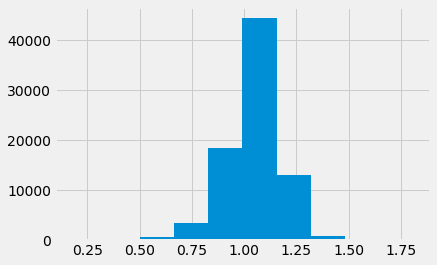

In [39]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [40]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(4990, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,8248,PACT,16847,mhL,19.044093,3.927791,19.094881,70.330896,0.978552
2,7535,ROG SPUNJ,11789,Misfit,13.653199,1.989899,16.663300,63.332323,0.892862
3,9791,ROG pronax,17082,Ex6poN,17.221662,3.267003,17.236776,70.496222,1.019471
4,8695,ROG nooky,18457,s1las,15.812395,5.000000,17.654941,68.485427,1.039347
5,7538,ROG fl0m,8503,fl0m,16.121724,4.516329,17.653793,70.428268,0.968740


### IEM CHICAGO - RANKING PLAYERS

So just as a review, we are looking at players weighted average kills, assists, deaths, and ADR from the past year. This was determined by exponentially decaying on their performanes. Essentially giving more weight to recent games than older games. From these features, I hope to be able to rank players reasonably well and also optimize against the fantasy leagues constraints (max: 1,000,000 USD team composition, player values [ex: 'Stewie2K' = 202,000 USD])

In [41]:
team_names = ['Liquid', 'Vitality', 'ENCE', 'G2', 'Heroic', 'MIBR', 'Renegades', 'Envy']

esl_one_players = true_player_df.loc[true_player_df['team_name'].isin(team_names), :]
print(esl_one_players.shape)
esl_one_players.head()

(53, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
48,9565,Vitality,7322,apEX,18.040862,5.587800,18.085492,75.894590,1.057475
56,9565,Vitality,7168,NBK-,17.340511,4.483169,18.824895,75.536522,1.034189
233,9565,Vitality,11893,ZywOo,22.008730,5.067405,16.103834,85.000250,1.311745
241,4869,ENCE,4076,Aerial,17.216427,4.049537,17.438859,73.518346,1.086494
242,4869,ENCE,695,allu,18.862452,4.124966,16.167395,73.430160,1.138309


In [42]:
esl_one_players.sort_values(['true_rating'], ascending=False)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
233,9565,Vitality,11893,ZywOo,22.008730,5.067405,16.103834,85.000250,1.311745
3921,6211,Renegades,11271,smooya,22.153550,5.618078,16.269173,81.811414,1.248640
346,5973,Liquid,8520,NAF,19.681174,6.382247,16.844032,85.721372,1.247811
325,5973,Liquid,8738,EliGE,21.002228,4.973881,17.398288,85.218538,1.243468
955,7175,Heroic,15165,blameF,21.026329,5.267953,17.405081,83.566109,1.218233
980,5995,G2,7167,kennyS,21.105039,4.670517,16.949837,79.264573,1.206361
352,5973,Liquid,10394,Twistzz,20.160784,3.672672,15.546796,74.980167,1.200870
441,6211,Renegades,4679,jks,20.388810,4.094949,17.261011,82.590898,1.187507
1040,5995,G2,8374,bodyy,16.660291,4.502210,14.248797,78.495707,1.185106
308,4869,ENCE,11916,sergej,19.521581,3.904968,16.895029,80.875783,1.175967


### Considerations only data where teams have played each other

In [43]:
path = '../data/master_players'
files = listdir(path)

# Import data
player_df = pd.DataFrame()
for file in files:
    file_df = pd.read_csv(os.path.join(path, file))
    player_df = player_df.append(file_df, ignore_index=True, sort=False)
    
# Convert unix time stamp to date time
player_df['date'] = player_df['date'] / 1000
player_df['date'] = pd.to_datetime(player_df['date'], unit ='s')
    
# Consider historical from 2018 to present
player_df = player_df.loc[player_df['date'] >= '2019-01-01 00:00:00', :]

# Keep only date
player_df['date'] = player_df['date'].dt.date

# Drop rows with NaN in KAST or ADR
player_df = player_df.loc[-player_df['KAST'].isna(), :]
player_df = player_df.loc[-player_df['ADR'].isna(), :]
player_df.reset_index(drop=True, inplace=True)
    
print(player_df.shape)
player_df.tail()

(81219, 20)


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
81214,89227,d2,2019-07-15,10111,absolute mad lads,6455,OCEAN,12,6,4,1,17,66.7,-5,55.8,-2,0.75,0.50,0.71,0.52
81215,89228,ovp,2019-07-16,8668,ORDER,11140,INS,11,6,9,1,15,80.0,-4,80.4,1,1.04,0.55,0.75,1.16
81216,89229,mrg,2019-07-16,8668,ORDER,16323,Valiance,14,6,5,1,18,69.2,-4,72.1,-1,0.86,0.54,0.69,0.54
81217,89230,nuke,2019-07-16,8813,Illuminar,9916,mono,13,5,6,4,14,68.0,-1,57.2,-2,0.87,0.52,0.56,0.41
81218,89231,ovp,2019-07-16,8813,Illuminar,3669,innocent,14,8,7,1,20,65.5,-6,59.1,0,0.83,0.48,0.69,0.70


In [44]:
# Subset dataframe by maps where only the teams in the tournament have played each other
team_names = ['Liquid', 'Vitality', 'ENCE', 'G2', 'Heroic', 'MIBR', 'Renegades', 'Envy']

# Only data from the teams of interest
player_df = player_df.loc[player_df['team_name'].isin(team_names),:]

# Find map_ids that are shared between teams
shared_ids = []
all_ids = []
for team in team_names:
    team_df = player_df.loc[player_df['team_name'] == team, :]
    map_ids = list(team_df['map_id'].unique())

    # Check if map_id has already been collected
    for map_id in map_ids:
        if map_id in all_ids:
            shared_ids.append(map_id)
            
    all_ids = all_ids + list(map_ids)
    
print('Number of matches between all teams:', len(shared_ids))

# Collect only matches between teams in the tourny
player_df = player_df.loc[player_df['map_id'].isin(shared_ids),:]
player_df.head()

Number of matches between all teams: 96


,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact
1324,81427,ovp,2019-02-13,4869,ENCE,695,allu,21,5,4,2,11,68.2,10,89.3,2,1.52,0.95,0.50,1.64
1336,81446,nuke,2019-02-14,4869,ENCE,11916,sergej,14,10,5,1,18,73.9,-4,77.9,0,1.02,0.61,0.78,1.02
1338,81449,mrg,2019-02-14,4869,ENCE,9816,Aleksib,23,8,10,5,22,66.7,1,81.2,3,1.19,0.77,0.73,1.50
1521,81662,inf,2019-02-20,4869,ENCE,11916,sergej,23,8,2,0,15,79.3,8,74.8,4,1.28,0.79,0.52,1.28
1571,81719,inf,2019-02-21,9215,MIBR,9216,coldzera,35,19,4,1,18,78.6,17,111.5,2,1.68,1.25,0.64,1.88


In [81]:
team = 'G2'
player_df[(player_df['team_name'] == team) &
          (player_df['map_id'].isin(shared_ids))]['map_id'].unique()

array([88128, 88133, 88382, 88386, 88387, 88388, 81427, 81719, 81828,
       81830, 83088, 83103, 83112, 84444, 84448, 84451, 86710, 86788,
       86803, 86810, 86880, 86884, 86890, 88260, 88266])

In [84]:
player_df[player_df['map_id'].isin([86890])].sort_values(by=['team_name', 'rating'], ascending=False)

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
6104,86890,trn,2019-05-30,6211,Renegades,4679,jks,22,10,4,1,20,72.4,2,88.3,4,1.15,0.76,0.69,1.06,48.0,0.231763,0.052691
22348,86890,trn,2019-05-30,6211,Renegades,8248,jkaem,20,5,3,1,21,62.1,-1,77.7,4,1.06,0.69,0.72,1.31,48.0,0.231763,0.052691
38592,86890,trn,2019-05-30,6211,Renegades,9686,Gratisfaction,19,3,5,4,17,72.4,2,68.7,2,1.06,0.66,0.59,0.96,48.0,0.231763,0.079383
54835,86890,trn,2019-05-30,6211,Renegades,8082,AZR,14,10,6,0,18,58.6,-4,63.2,-4,0.84,0.48,0.62,0.81,48.0,0.231763,0.052691
71079,86890,trn,2019-05-30,6211,Renegades,10588,Liazz,14,4,3,2,19,65.5,-5,48.9,-3,0.81,0.48,0.66,0.69,48.0,0.231763,0.052691
14226,86890,trn,2019-05-30,5995,G2,9616,AmaNEk,29,13,4,0,15,69.0,14,93.3,-1,1.44,1.00,0.52,1.69,48.0,0.231763,0.042521
30470,86890,trn,2019-05-30,5995,G2,284,JaCkz,20,7,6,1,21,79.3,-1,76.0,2,1.13,0.69,0.72,1.25,48.0,0.231763,0.042167
46713,86890,trn,2019-05-30,5995,G2,1225,shox,19,8,9,3,17,82.8,2,68.2,0,1.09,0.66,0.59,0.73,48.0,0.231763,0.042167
62957,86890,trn,2019-05-30,5995,G2,13497,Lucky,12,4,5,0,17,79.3,-5,60.0,-6,0.97,0.41,0.59,0.78,48.0,0.231763,0.042167
79201,86890,trn,2019-05-30,5995,G2,7167,kennyS,15,3,2,0,20,62.1,-5,48.8,2,0.76,0.52,0.69,0.57,48.0,0.231763,0.042167


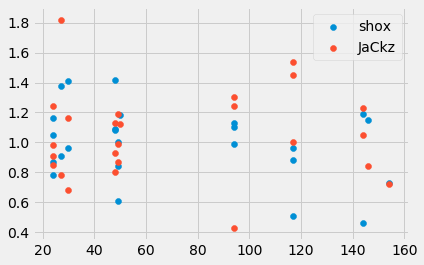

In [110]:
p1 = 'shox'
p2 = 'JaCkz'

plt.scatter(player_df.loc[player_df['player_name'] == p1, 'days_from_today'], player_df.loc[player_df['player_name'] == p1, 'rating'].values, label=p1)
plt.scatter(player_df.loc[player_df['player_name'] == p2, 'days_from_today'], player_df.loc[player_df['player_name'] == p2, 'rating'].values, label=p2)
plt.legend()
plt.show()

In [94]:
player_df.loc[player_df['player_name'] == 'jks', :]

datetime.date(2019, 7, 14)

In [93]:
player_df['date'].max()

datetime.date(2019, 7, 14)

In [45]:
# Number of days from today
current_datetime = pd.Timestamp('today').date()
player_df['days_from_today'] = (current_datetime - player_df['date']) / np.timedelta64(1, 'D')

# Exponential Decay from today
def exp_decay(days, a=1, r=0.03):
    '''
    @days: days from today
    @a: initial value
    @r: decay rate
    '''
    return a * (1 - r) ** days

player_df['decay'] = player_df['days_from_today'].apply(exp_decay)

# Normalize decay on a per player basis
player_df['normalized_decay'] = player_df['decay'] / player_df.groupby('player_id')['decay'].transform('sum')

player_df.head()

,map_id,map,date,team_id,team_name,player_id,player_name,kills,hs_kills,assists,flash_assists,deaths,KAST,kill_death_diff,ADR,first_kills_diff,rating,kills_per_round,deaths_per_round,impact,days_from_today,decay,normalized_decay
1324,81427,ovp,2019-02-13,4869,ENCE,695,allu,21,5,4,2,11,68.2,10,89.3,2,1.52,0.95,0.50,1.64,154.0,0.009180,0.001482
1336,81446,nuke,2019-02-14,4869,ENCE,11916,sergej,14,10,5,1,18,73.9,-4,77.9,0,1.02,0.61,0.78,1.02,153.0,0.009464,0.001528
1338,81449,mrg,2019-02-14,4869,ENCE,9816,Aleksib,23,8,10,5,22,66.7,1,81.2,3,1.19,0.77,0.73,1.50,153.0,0.009464,0.001528
1521,81662,inf,2019-02-20,4869,ENCE,11916,sergej,23,8,2,0,15,79.3,8,74.8,4,1.28,0.79,0.52,1.28,147.0,0.011362,0.001834
1571,81719,inf,2019-02-21,9215,MIBR,9216,coldzera,35,19,4,1,18,78.6,17,111.5,2,1.68,1.25,0.64,1.88,146.0,0.011713,0.004376


In [46]:
# Aggregation on features with exponential decay to get current state of player
def player_features_normalized(stuff):
    new_df = pd.DataFrame()
    new_df['map_id'] = stuff['map_id']
    new_df['map'] = stuff['map']
    new_df['team_id'] = stuff['team_id']
    new_df['team_name'] = stuff['team_name']
    new_df['player_id'] = stuff['player_id']
    new_df['player_name'] = stuff['player_name']
    
    
    # Normalize features of interest
    columns = ['kills', 'assists', 'deaths', 'ADR', 'rating']
    for column in columns:
        new_df[column] = stuff[column] * stuff['normalized_decay']
    
    return new_df

player_norm_df = player_features_normalized(player_df)
player_norm_df.head()

,map_id,map,team_id,team_name,player_id,player_name,kills,assists,deaths,ADR,rating
1324,81427,ovp,4869,ENCE,695,allu,0.031117,0.005927,0.016299,0.132320,0.002252
1336,81446,nuke,4869,ENCE,11916,sergej,0.021386,0.007638,0.027496,0.118998,0.001558
1338,81449,mrg,4869,ENCE,9816,Aleksib,0.035134,0.015276,0.033607,0.124039,0.001818
1521,81662,inf,4869,ENCE,11916,sergej,0.042179,0.003668,0.027508,0.137175,0.002347
1571,81719,inf,9215,MIBR,9216,coldzera,0.153171,0.017505,0.078774,0.487960,0.007352


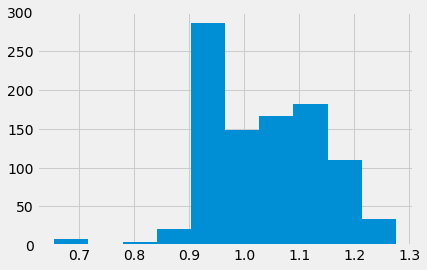

In [47]:
# Create 'true' features counts (sum up a feature)
player_norm_df['true_kills'] = player_norm_df.groupby('player_id')['kills'].transform('sum')
player_norm_df['true_assists'] = player_norm_df.groupby('player_id')['assists'].transform('sum')
player_norm_df['true_deaths'] = player_norm_df.groupby('player_id')['deaths'].transform('sum')
player_norm_df['true_ADR'] = player_norm_df.groupby('player_id')['ADR'].transform('sum')
player_norm_df['true_rating'] = player_norm_df.groupby('player_id')['rating'].transform('sum')
player_norm_df['true_rating'].hist()
plt.show()

In [48]:
# Collect only the player and their 'true' features
true_player_df = player_norm_df.drop(columns=['map_id', 'map', 'kills', 'assists', 'deaths', 'ADR', 'rating']).drop_duplicates()
print(true_player_df.shape)
true_player_df.head()

(45, 9)


,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
1324,4869,ENCE,695,allu,17.687592,4.587967,16.957612,67.591971,1.038807
1336,4869,ENCE,11916,sergej,19.778131,3.832085,18.690592,80.419762,1.132315
1338,4869,ENCE,9816,Aleksib,16.246379,6.270646,18.296073,71.568351,0.989979
1571,9215,MIBR,9216,coldzera,19.571117,3.837673,16.910333,80.978765,1.126154
1625,6211,Renegades,4679,jks,21.300653,3.913054,18.623114,83.076356,1.164688


In [49]:
# Rank by rating
true_player_df.sort_values(['true_rating'], ascending=False).reset_index(drop=True)

,team_id,team_name,player_id,player_name,true_kills,true_assists,true_deaths,true_ADR,true_rating
0,9565,Vitality,11893,ZywOo,23.075387,4.282304,16.513553,84.654652,1.275507
1,5973,Liquid,8738,EliGE,21.751260,4.571916,17.806144,83.525147,1.211896
2,5973,Liquid,8520,NAF,19.031114,7.136378,17.470206,84.729380,1.207042
3,7175,Heroic,15165,blameF,20.976700,4.641010,17.995671,84.252684,1.197015
4,6211,Renegades,4679,jks,21.300653,3.913054,18.623114,83.076356,1.164688
5,5995,G2,7167,kennyS,19.843640,4.516896,17.306557,73.388496,1.143295
6,9215,MIBR,8564,fer,19.693591,3.470228,17.634042,79.132588,1.141442
7,5973,Liquid,10394,Twistzz,20.243805,3.284381,16.335716,73.810352,1.140089
8,4869,ENCE,11916,sergej,19.778131,3.832085,18.690592,80.419762,1.132315
9,7175,Heroic,9895,mertz,23.000000,4.333333,21.333333,77.100000,1.130000
